# Calculation of Molecular Descriptors

## Description
This notebook is designed to calculate molecular descriptors using RDKit and perform various data preprocessing tasks. The main steps involved in this notebook are:

1. **Importing Libraries**: Importing necessary libraries for molecular descriptor calculation, data manipulation, visualization, and machine learning.
2. **Data Loading and Preprocessing**: Loading the dataset, handling missing values, and scaling the data.
3. **Descriptor Calculation**: Using RDKit to calculate molecular descriptors for the compounds in the dataset.
4. **Feature Selection**: Applying feature selection techniques to reduce the dimensionality of the dataset.

The goal of this notebook is to provide a comprehensive workflow for data preprocessing and calculation of molecular descriptors for chemical datasets based on SMILES.

## 1. **import section**

In [27]:
import contextlib
import os
#----------------------------------------------------
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Descriptors import MoleculeDescriptors
#----------------------------------------------------
import pandas as pd
import numpy as np
#----------------------------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
#----------------------------------------------------
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay as PED
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
#----------------------------------------------------

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 2. **Data Loading and Preprocessing**

In [14]:
# load data (dataFrame of the with index and SMILE-string)
!pwd
df=pd.read_pickle("./data/processed/id_smile.pkl")

/home/sat/HL-gaps-pub


In [15]:
df

,SMILE
0,CC(=C)C1C2OC(=O)C1C1(O)CC3OC33C(=O)OC2C13C
1,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...
2,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...
3,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...
4,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...
...,...
406198,O=C(NCCN=C(O)C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F...
406199,O=C(O)C=CC1=C2NC(C=C3N=C(C=C4NC(=CC5=NC=6C(C(=...
406200,O[C]1[CH][C](O)[C]2[CH][C](OC3OC(CO)C(O)C(O)C3...
406201,O=C(N)C1C(=O)C(N(C)C)C2CC3CC4=C(C(=O)C3C(=O)C2...


In [16]:
# list possible descriptors
Descriptors._descList

[('MaxAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MaxAbsEStateIndex(mol, force=1)>),
 ('MaxEStateIndex',
  <function rdkit.Chem.EState.EState.MaxEStateIndex(mol, force=1)>),
 ('MinAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MinAbsEStateIndex(mol, force=1)>),
 ('MinEStateIndex',
  <function rdkit.Chem.EState.EState.MinEStateIndex(mol, force=1)>),
 ('qed',
  <function rdkit.Chem.QED.qed(mol, w=QEDproperties(MW=0.66, ALOGP=0.46, HBA=0.05, HBD=0.61, PSA=0.06, ROTB=0.65, AROM=0.48, ALERTS=0.95), qedProperties=None)>),
 ('SPS', <function rdkit.Chem.SpacialScore.SPS(mol, normalize=True)>),
 ('MolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('HeavyAtomMolWt', <function rdkit.Chem.Descriptors.HeavyAtomMolWt(x)>),
 ('ExactMolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('NumValenceElectrons',
  <function rdkit.Chem.Descriptors.NumValenceElectrons(mol)>),
 ('NumRadicalElectrons',
  <function rdkit.Chem.Descriptors.NumRadicalElectrons(mol)>),
 ('Ma

## 3. **Descriptor Calculation**

In [18]:
ldf=len(df)

In [21]:
# calc all desriptors for all (only 1000 SMILES where selected for demonstration, but you can adjust yourself)
ff=open("./progress.txt",mode='w')
with contextlib.redirect_stderr(open(os.devnull,'w')):
    def RDkit_descriptors(smiles):
        mols = [Chem.MolFromSmiles(i) for i in smiles] 
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                        for x in Descriptors._descList])
        desc_names = calc.GetDescriptorNames()

        Mol_descriptors =[]
        for idx,mol in enumerate(mols):
            #report progress nevery tasks finished
            report_nevery=10000
            if idx % report_nevery==0:
                print(idx,'/',ldf," (",idx/ldf*100,"%)")
                ff.write("{:<7d}{:<7d}{:<4.2f}{:<3s}\n".format(idx,ldf,idx/ldf*100,' %'))
                ff.flush()
            # add hydrogens to molecules
            mol=Chem.AddHs(mol)
            # Calculate all 200 descriptors for each molecule
            descriptors = calc.CalcDescriptors(mol)
            Mol_descriptors.append(descriptors)
        return Mol_descriptors,desc_names 
    # Select a subsample of df['SMILE'] using iloc
    subsample_indices = range(0, 1000)  # specify the indices of the samples you want
    df_subsample = df['SMILE'].iloc[subsample_indices]
    
    # Function call
    Mol_descriptors,desc_names = RDkit_descriptors(df_subsample)
ff.close()

0 / 406203  ( 0.0 %)


In [22]:
df_descr = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_descr

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.421670,13.421670,1.813652,-4.213449,0.413812,93.904762,292.287,276.159,292.094688,112,...,0,0,0,0,0,0,0,0,0,0
1,14.938999,14.938999,0.626931,-6.373747,0.036669,66.444444,660.651,624.363,660.183639,250,...,0,0,0,0,0,0,0,0,0,0
2,15.674552,15.674552,1.517576,-4.913705,0.264609,45.409091,598.604,568.364,598.183897,226,...,0,0,0,0,0,0,0,0,0,0
3,15.162100,15.162100,1.184590,-4.773941,0.251494,45.804878,554.551,528.343,554.157682,208,...,0,0,0,0,0,0,0,0,0,0
4,14.690159,14.690159,1.393863,-6.473465,0.284610,57.538462,534.693,492.357,534.298139,210,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.381412,7.381412,0.054514,-2.509120,0.537602,19.000000,135.126,130.086,135.043262,50,...,0,0,0,0,0,0,0,0,0,0
996,7.565324,7.565324,0.019213,-0.413519,0.556074,17.000000,135.126,130.086,135.043262,50,...,0,0,0,0,0,0,0,0,0,0
997,7.472824,7.472824,0.010000,-0.436667,0.556074,17.000000,135.126,130.086,135.043262,50,...,0,0,0,0,0,0,0,0,0,0
998,7.477130,7.477130,0.077778,-0.411268,0.568272,19.600000,135.126,130.086,135.043262,50,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

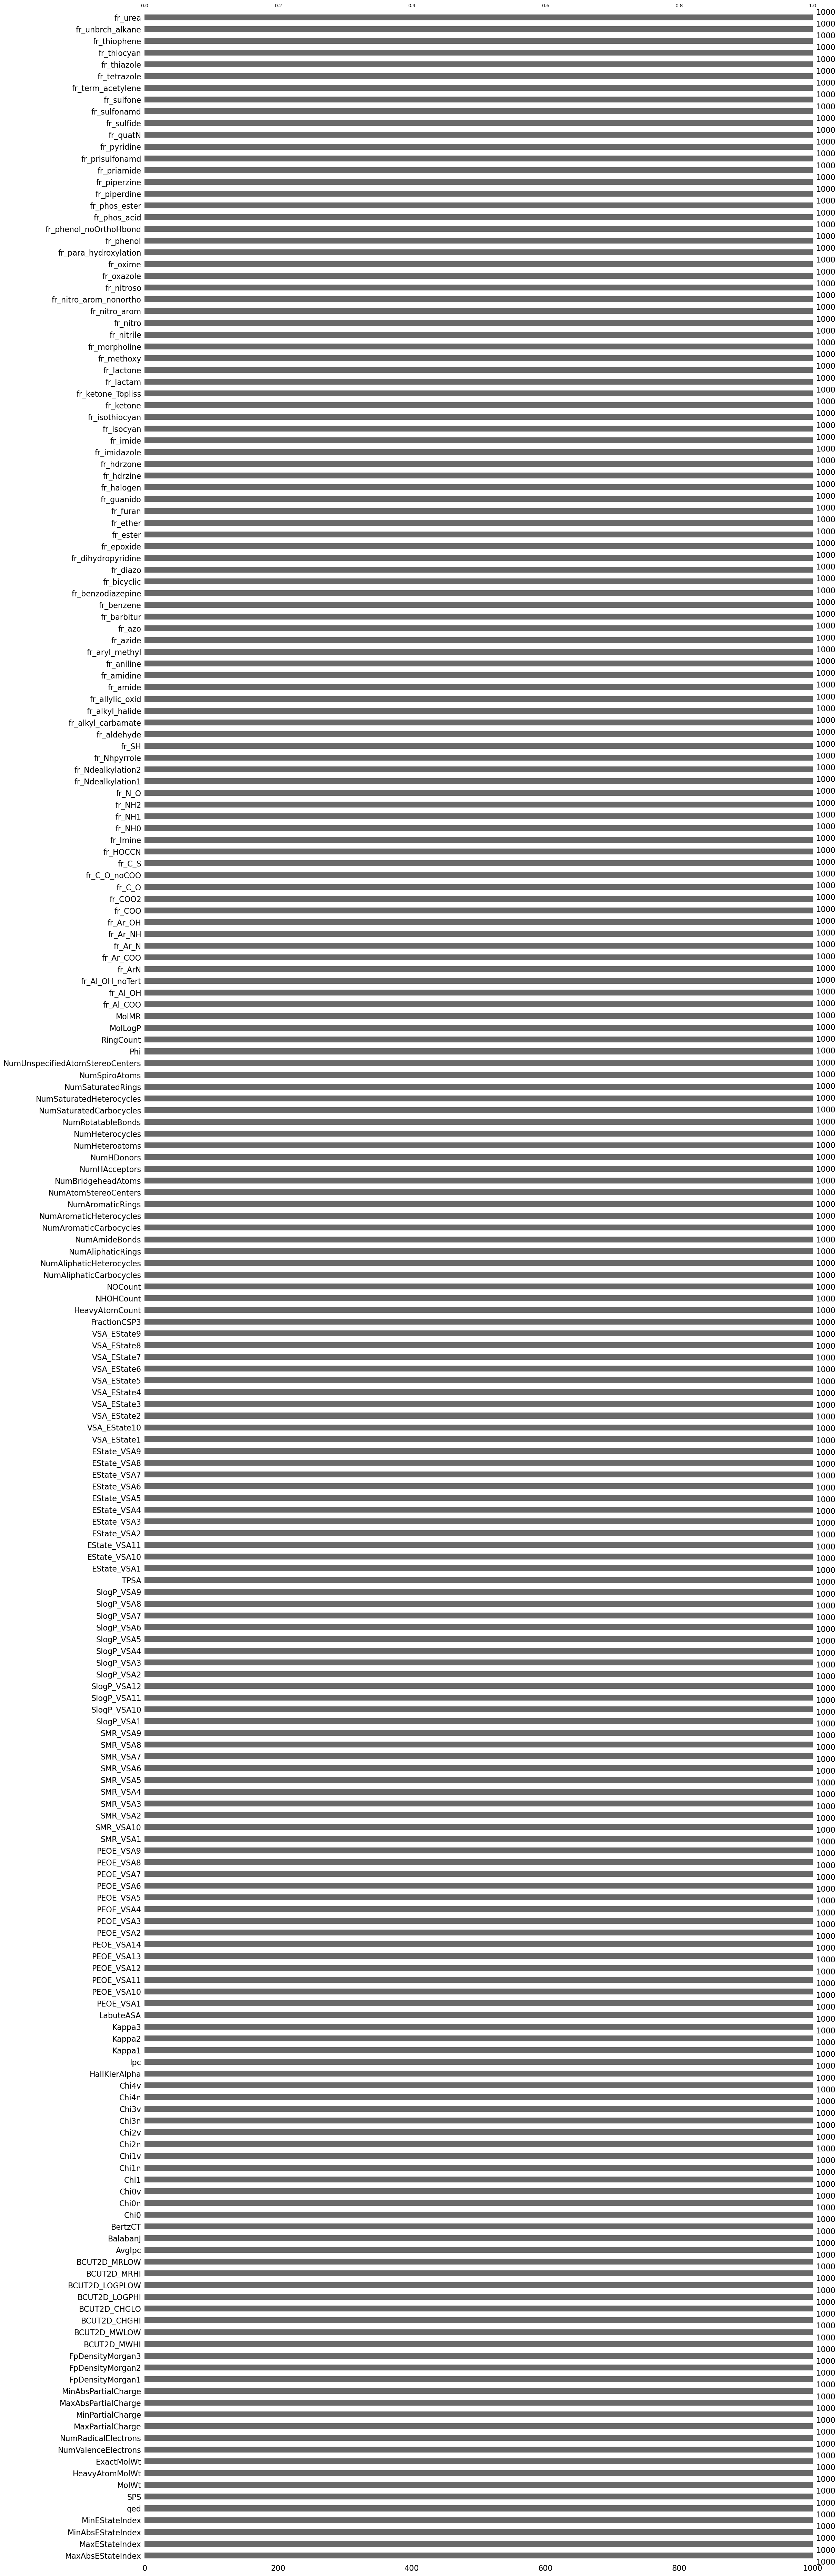

In [23]:
# check for missing values
msno.bar(df_descr)

## 4. **Feature Selection**

In [24]:
def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.75)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped

df_descr = remove_correlated_features(df_descr)
df_descr

['MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA12', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA6', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState2', 'VSA_EState3', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7',

,MaxAbsEStateIndex,NumRadicalElectrons,MinPartialCharge,BCUT2D_MWHI,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA11,PEOE_VSA13,PEOE_VSA3,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.421670,0,-0.457400,16.688455,2.128362,-1.40,4.183777e+07,6.080018,0.000000,4.794537,...,0,0,0,0,0,0,0,0,0,0
1,14.938999,0,-0.477487,32.116812,3.117964,-3.23,2.855468e+15,26.554076,1.431200,14.581479,...,0,0,0,0,0,0,0,0,0,0
2,15.674552,0,-0.495957,16.557976,1.857894,-4.67,5.792987e+14,5.783245,0.000000,4.794537,...,0,0,0,0,0,0,0,0,0,0
3,15.162100,0,-0.507159,16.557655,1.856690,-4.47,4.391759e+13,5.783245,1.431200,4.794537,...,0,0,0,0,0,0,0,0,0,0
4,14.690159,0,-0.465268,16.591194,2.630768,-3.15,1.867393e+15,0.000000,0.000000,9.589074,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.381412,0,-0.336587,16.473067,2.761423,-1.45,2.369781e+03,5.760247,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
996,7.565324,0,-0.493600,16.266578,2.858287,-1.58,2.787419e+03,7.236247,1.431200,10.075685,...,0,0,0,0,0,0,0,0,0,0
997,7.472824,0,-0.480362,16.275378,2.870931,-1.58,2.854929e+03,1.411842,7.441664,4.983979,...,0,0,0,0,0,0,0,0,0,0
998,7.477130,0,-0.431361,16.341901,3.122936,-1.58,2.936594e+03,1.411842,5.684503,4.983979,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# replace inf values with nan and drop nan columns
df_descr=df_descr.dropna(axis='columns')
df_descr.replace([np.inf, -np.inf], np.nan, inplace=True)
zero_cols = df_descr.columns[(df_descr == 0).all()]
df_descr.drop(labels=zero_cols, axis=1, inplace=True)
# scale "Ipc" diffenrently
df_descr["Ipc"]=df_descr["Ipc"].apply(lambda x: np.log10(x))
df_descr["Ipc"]
df_descr

,MaxAbsEStateIndex,MinPartialCharge,BCUT2D_MWHI,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA11,PEOE_VSA13,PEOE_VSA3,PEOE_VSA4,...,fr_nitroso,fr_oxazole,fr_oxime,fr_piperdine,fr_piperzine,fr_pyridine,fr_quatN,fr_sulfide,fr_term_acetylene,fr_thiophene
0,13.421670,-0.457400,16.688455,2.128362,-1.40,7.621569,6.080018,0.000000,4.794537,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,14.938999,-0.477487,32.116812,3.117964,-3.23,15.455677,26.554076,1.431200,14.581479,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,15.674552,-0.495957,16.557976,1.857894,-4.67,14.762903,5.783245,0.000000,4.794537,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,15.162100,-0.507159,16.557655,1.856690,-4.47,13.642638,5.783245,1.431200,4.794537,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,14.690159,-0.465268,16.591194,2.630768,-3.15,15.271236,0.000000,0.000000,9.589074,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.381412,-0.336587,16.473067,2.761423,-1.45,3.374708,5.760247,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
996,7.565324,-0.493600,16.266578,2.858287,-1.58,3.445202,7.236247,1.431200,10.075685,5.098682,...,0,0,0,0,0,0,0,0,0,0
997,7.472824,-0.480362,16.275378,2.870931,-1.58,3.455595,1.411842,7.441664,4.983979,0.000000,...,0,0,0,0,0,0,0,0,0,0
998,7.477130,-0.431361,16.341901,3.122936,-1.58,3.467844,1.411842,5.684503,4.983979,0.000000,...,0,1,0,0,0,0,0,0,0,0


In [28]:
# credit to dataprofessor
# adapted from:https://github.com/dataprofessor/padel/blob/main/padelpy.ipynb

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

df_descr = remove_low_variance(df_descr, threshold=0.15)
df_descr

,MaxAbsEStateIndex,BCUT2D_MWHI,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA11,PEOE_VSA13,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,...,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticRings,NumBridgeheadAtoms,NumHeterocycles,RingCount,fr_Ar_OH,fr_allylic_oxid,fr_bicyclic,fr_ketone
0,13.421670,16.688455,2.128362,-1.40,7.621569,6.080018,0.000000,4.794537,0.000000,0.000000,...,5,0,0,2,3,5,0,0,4,0
1,14.938999,32.116812,3.117964,-3.23,15.455677,26.554076,1.431200,14.581479,0.000000,12.532696,...,3,0,0,0,2,3,0,2,0,2
2,15.674552,16.557976,1.857894,-4.67,14.762903,5.783245,0.000000,4.794537,0.000000,0.000000,...,4,0,3,0,1,7,0,1,6,2
3,15.162100,16.557655,1.856690,-4.47,13.642638,5.783245,1.431200,4.794537,0.000000,0.000000,...,4,0,3,0,1,7,1,1,6,2
4,14.690159,16.591194,2.630768,-3.15,15.271236,0.000000,0.000000,9.589074,0.000000,0.000000,...,2,0,2,0,0,4,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.381412,16.473067,2.761423,-1.45,3.374708,5.760247,0.000000,0.000000,0.000000,5.098682,...,2,0,0,0,2,2,0,0,1,0
996,7.565324,16.266578,2.858287,-1.58,3.445202,7.236247,1.431200,10.075685,5.098682,0.000000,...,2,0,0,0,2,2,1,0,1,0
997,7.472824,16.275378,2.870931,-1.58,3.455595,1.411842,7.441664,4.983979,0.000000,0.000000,...,2,0,0,0,2,2,1,0,1,0
998,7.477130,16.341901,3.122936,-1.58,3.467844,1.411842,5.684503,4.983979,0.000000,0.000000,...,0,2,2,0,2,2,0,0,1,0


In [29]:
df_descr[np.isfinite(df_descr).any(axis=1)]

,MaxAbsEStateIndex,BCUT2D_MWHI,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA11,PEOE_VSA13,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,...,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticRings,NumBridgeheadAtoms,NumHeterocycles,RingCount,fr_Ar_OH,fr_allylic_oxid,fr_bicyclic,fr_ketone
0,13.421670,16.688455,2.128362,-1.40,7.621569,6.080018,0.000000,4.794537,0.000000,0.000000,...,5,0,0,2,3,5,0,0,4,0
1,14.938999,32.116812,3.117964,-3.23,15.455677,26.554076,1.431200,14.581479,0.000000,12.532696,...,3,0,0,0,2,3,0,2,0,2
2,15.674552,16.557976,1.857894,-4.67,14.762903,5.783245,0.000000,4.794537,0.000000,0.000000,...,4,0,3,0,1,7,0,1,6,2
3,15.162100,16.557655,1.856690,-4.47,13.642638,5.783245,1.431200,4.794537,0.000000,0.000000,...,4,0,3,0,1,7,1,1,6,2
4,14.690159,16.591194,2.630768,-3.15,15.271236,0.000000,0.000000,9.589074,0.000000,0.000000,...,2,0,2,0,0,4,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.381412,16.473067,2.761423,-1.45,3.374708,5.760247,0.000000,0.000000,0.000000,5.098682,...,2,0,0,0,2,2,0,0,1,0
996,7.565324,16.266578,2.858287,-1.58,3.445202,7.236247,1.431200,10.075685,5.098682,0.000000,...,2,0,0,0,2,2,1,0,1,0
997,7.472824,16.275378,2.870931,-1.58,3.455595,1.411842,7.441664,4.983979,0.000000,0.000000,...,2,0,0,0,2,2,1,0,1,0
998,7.477130,16.341901,3.122936,-1.58,3.467844,1.411842,5.684503,4.983979,0.000000,0.000000,...,0,2,2,0,2,2,0,0,1,0


<Axes: >

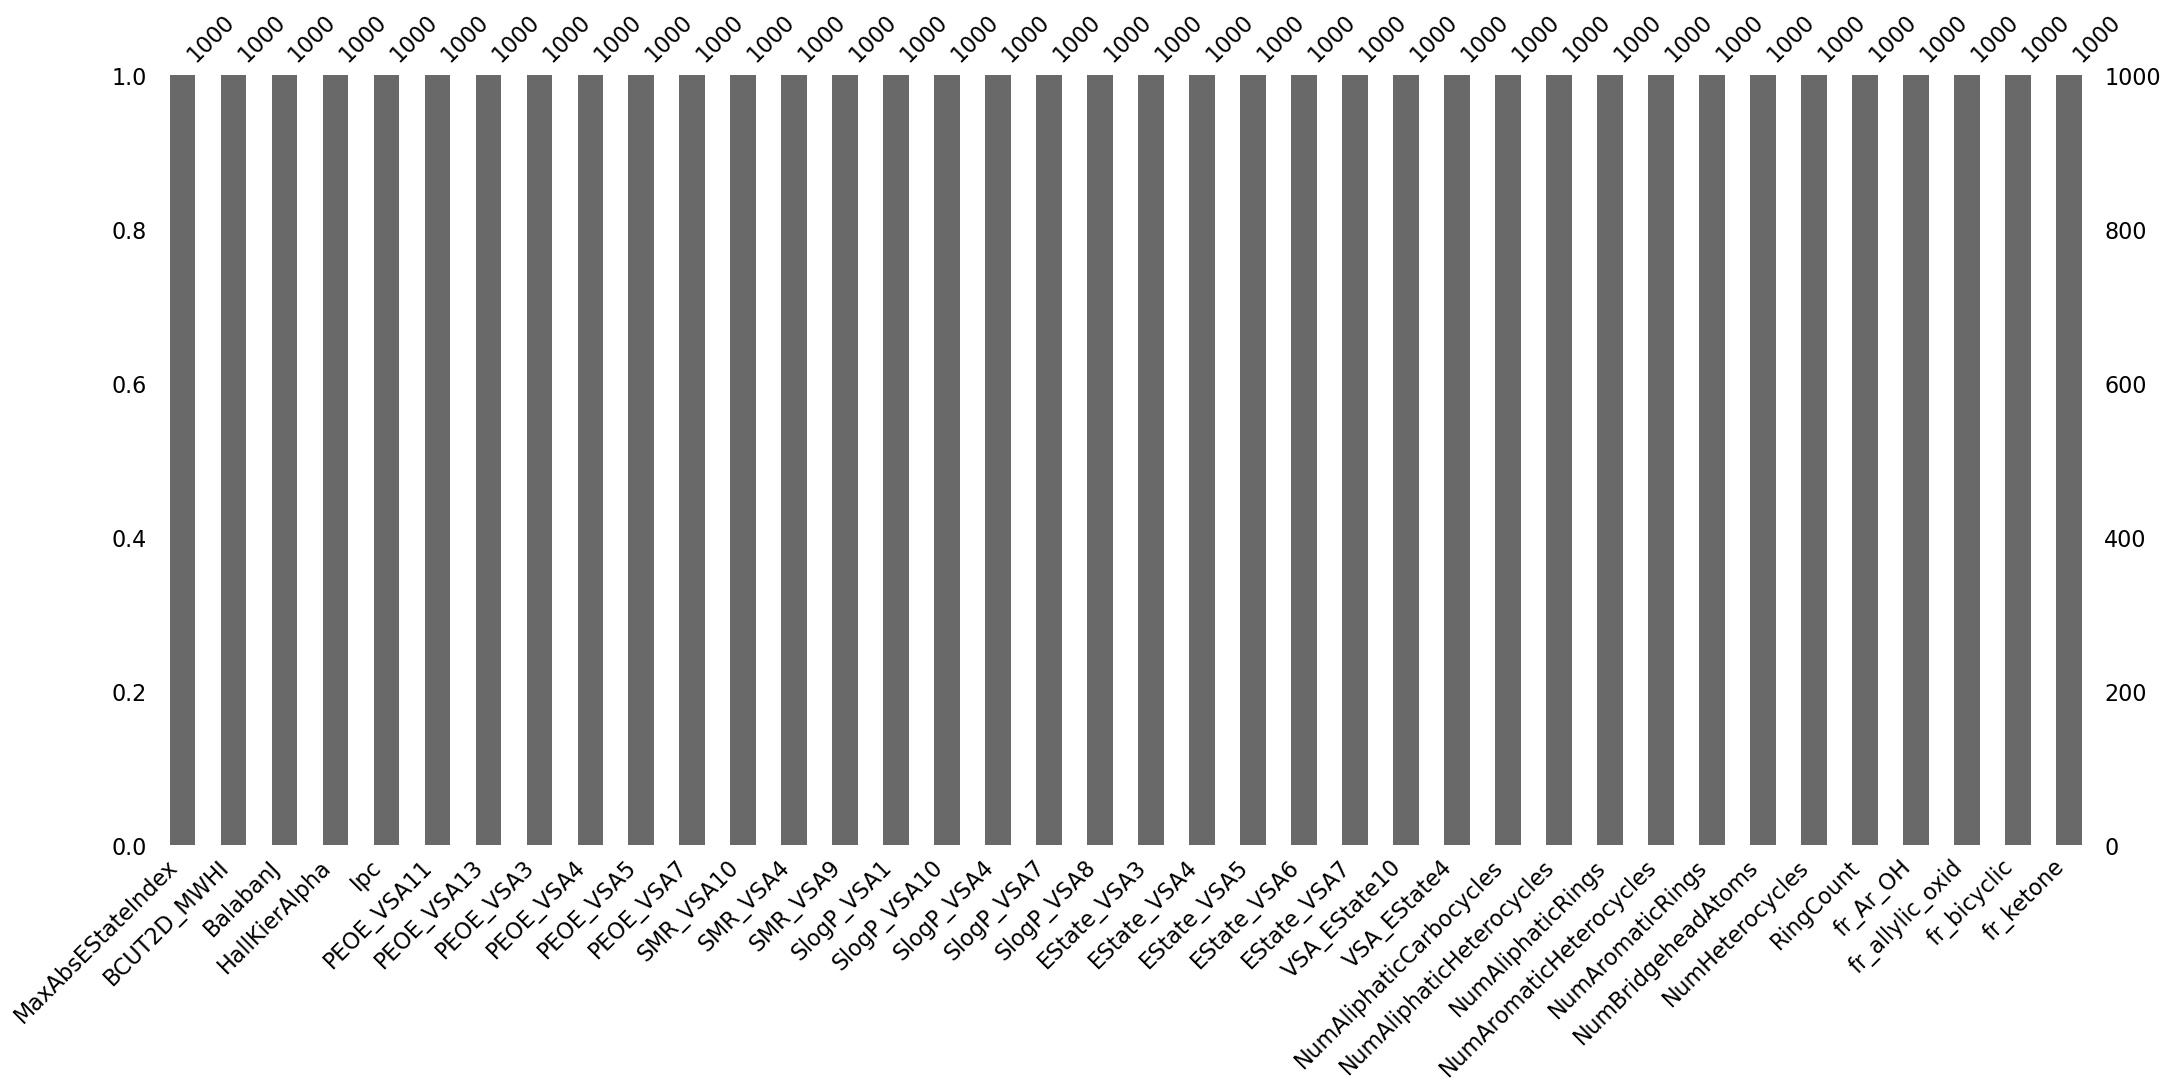

In [30]:
msno.bar(df_descr)

In [ ]:
#uncomment to save it overrides the pre-calculated data for the whole set
#df_descr.to_pickle("./data/processed/calc_descriptors_final_.pkl")